In [1]:
import numpy as np
import random
import pandas as pd
import time
import datetime
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('DataAugmentation.csv')

In [3]:
train_data['label'] = train_data['labels']

In [4]:
train_data = train_data.drop(columns=['labels'])

In [5]:
train_data = train_data[['text', 'label']]

In [6]:
x_data = train_data['text']
y_data = train_data['label']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=43)

In [8]:
x_train = x_train.values
y_train = y_train.values

x_test = x_test.values
y_test = y_test.values

In [9]:
modelPath = "Model/XLMRobertaBase/"

In [10]:
import torch
from transformers import BertTokenizer, AutoTokenizer, AutoModelForMaskedLM, XLMRobertaForSequenceClassification, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

In [11]:
torch.cuda.empty_cache()
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

#If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: CUDA GPU


In [12]:
def preProcessing(data, maxLength, tokenizer):    
    for tweet in data:
        encoded = tokenizer.encode_plus(
                    tweet, #Sentence to be tokenized
                    add_special_tokens=True, #Adding [CLS] a token added to beggining of the setence
                                             #and [SEP] a token added to end of the setence
                    max_length=maxLength, #the max size of the setence
                    padding='max_length',#pad_to_max_length = True, #Adding [PAD] a token that represents the real sentence(when the setence is  
                                              #smaller than the max size the spaces will be completed with this token)                                              
                    return_attention_mask=True, #An array of 0 and 1 indicating which tokens are [PAD](space in blank) 
                                                #and the tokens belonging to the sentence
                    return_tensors = 'pt', #Return pytorch tensors(the same as numpy array)
        )
        
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])    

In [13]:
#Loading locally the bert model
bert_tokenizer = AutoTokenizer.from_pretrained(modelPath, local_files_only=True)

In [14]:
input_ids = []
attention_masks = []

# Tokenizing the senteces of the train dataset
preProcessing(x_train, 512, bert_tokenizer)

#torch.cat concatenate the tensors 
inputId = torch.cat(input_ids, dim=0)
attentionMask = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train)
labels = torch.tensor(y_train).unsqueeze(1)
labels = labels.to(torch.int64)


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

In [16]:
#TensorDataset encapsulates the data
data = TensorDataset(inputId, attentionMask, labels)

In [17]:
# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

# Divide the dataset by randomly selecting samples.
train_data, valid_data = random_split(data, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

15,488 training samples
3,872 validation samples


In [18]:
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
# Dataloders wrap the data to offer a beter perfomance during the iteration
train_dataloader = DataLoader(
            train_data,  # The training samples.
            sampler = RandomSampler(train_data), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
valid_dataloader = DataLoader(
            valid_data, # The validation samples.
            sampler = SequentialSampler(valid_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
bertModel = XLMRobertaForSequenceClassification.from_pretrained(modelPath, local_files_only=True, 
                                                          num_labels = 2, # The number of output labels--2 for binary classification.
                                                                          # You can increase this for multi-class tasks.   
                                                          output_attentions = False, # Whether the model returns attentions weights.
                                                          output_hidden_states = False,)

Some weights of the model checkpoint at Model/XLMRobertaBase/ were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Model/XLMRobertaBase/ and are newly initialized: ['classi

In [20]:
#To run the model in the GPU
bertModel.cuda();

In [21]:
# AdamW optimizer reference https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = AdamW(bertModel.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [23]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [26]:
#bertModel.config.problem_type = "single_label_classification"

In [27]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bertModel.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        
        b_input_ids = batch[0].to(device)#.long()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)       
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        bertModel.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = bertModel(b_input_ids,         
                             token_type_ids=None, 
                             attention_mask=b_input_mask,
                             labels=b_labels
                             ,return_dict=False)
                    
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bertModel.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bertModel.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)#.long()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = bertModel(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels 
                                   ,return_dict=False) 
            
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    968.    Elapsed: 0:00:08.
  Batch    80  of    968.    Elapsed: 0:00:14.
  Batch   120  of    968.    Elapsed: 0:00:20.
  Batch   160  of    968.    Elapsed: 0:00:26.
  Batch   200  of    968.    Elapsed: 0:00:32.
  Batch   240  of    968.    Elapsed: 0:00:38.
  Batch   280  of    968.    Elapsed: 0:00:44.
  Batch   320  of    968.    Elapsed: 0:00:51.
  Batch   360  of    968.    Elapsed: 0:00:57.
  Batch   400  of    968.    Elapsed: 0:01:03.
  Batch   440  of    968.    Elapsed: 0:01:09.
  Batch   480  of    968.    Elapsed: 0:01:15.
  Batch   520  of    968.    Elapsed: 0:01:21.
  Batch   560  of    968.    Elapsed: 0:01:27.
  Batch   600  of    968.    Elapsed: 0:01:33.
  Batch   640  of    968.    Elapsed: 0:01:40.
  Batch   680  of    968.    Elapsed: 0:01:46.
  Batch   720  of    968.    Elapsed: 0:01:52.
  Batch   760  of    968.    Elapsed: 0:01:58.
  Batch   800  of    968.    Elapsed: 0:02:04.
  Batch   840  of

In [28]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.23,0.18,0.94,0:02:30,0:00:10
2,0.17,0.17,0.94,0:02:28,0:00:10
3,0.15,0.16,0.94,0:02:28,0:00:10
4,0.13,0.17,0.94,0:02:28,0:00:10


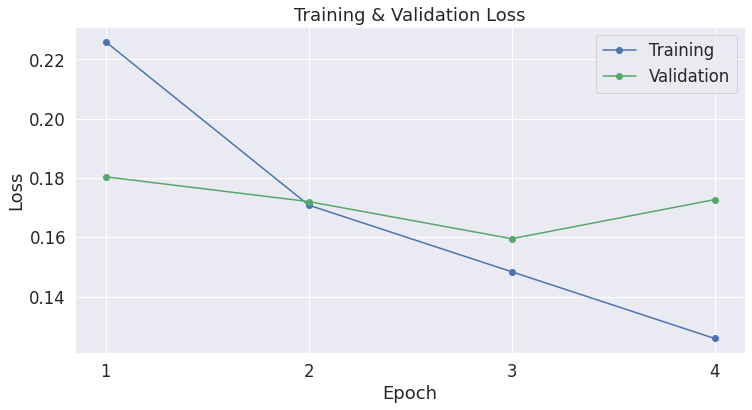

In [29]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Test

In [30]:
input_ids = []
attention_masks = []

# Tokenizing the senteces of the train dataset
preProcessing(x_test, 512, bert_tokenizer)

#torch.cat concatenate the tensors 
inputId = torch.cat(input_ids, dim=0)
attentionMask = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)
labels = torch.tensor(y_test).unsqueeze(1)
labels = labels.to(torch.int64)

In [31]:
# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data = TensorDataset(inputId, attentionMask, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
bertModel.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bertModel(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,840 test sentences...
    DONE.


In [33]:
from sklearn.metrics import f1_score

In [34]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [35]:
f1_score(flat_true_labels, flat_predictions)

0.6728110599078341

In [36]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


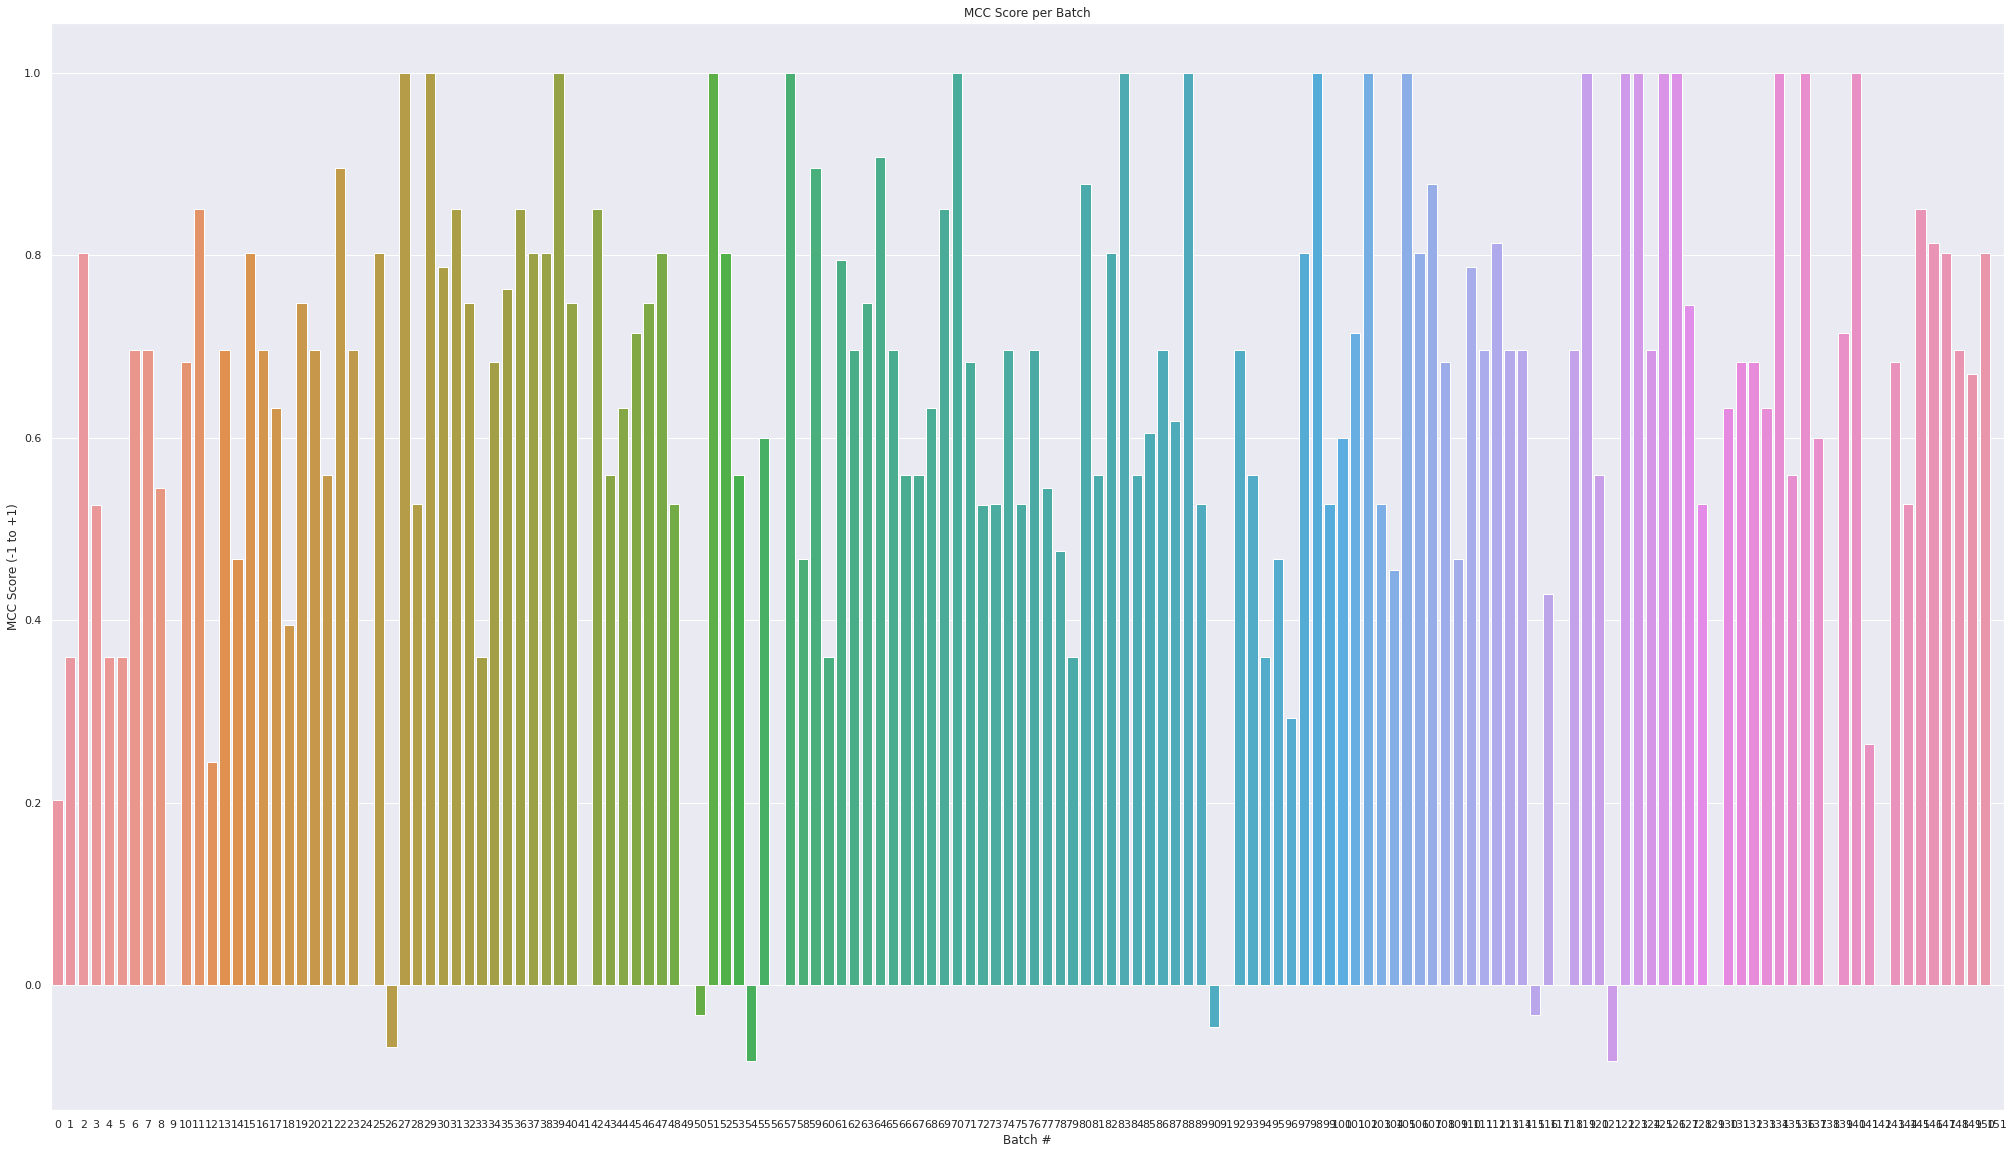

In [37]:
# Create a barplot showing the MCC score for each batch of test samples.
sns.set(rc={'figure.figsize':(35,20)})

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [38]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.642
